In [45]:
import xarray as xr
import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import datetime as dt
import click
import sys,os

In [150]:
# import module "cloud filter"
sys.path.append('/homedata/nmpnguyen/ipral-tools/')
from ipral_chm15k_cloud_filter import ipral_remove_cloud_profiles
# from imp import reload as rl
# rl(ipral_chm15k_cloud_filter)

'''
Le script est pour tester la méthode Rayleigh Fit à un jour de données Ipral.
Appliquer sur tous les profils, non ou ayant average time. 

La méthode de Rayleigh Fit change au niveau de calcul l'épaisseur d'optique. On change les bornes de l'intégration, sépararer l'intégration en fonction de l'altitude référence. 

'''
def correction_background(fileipral, channel):
    signal = fileipral[channel]
    bckgrd = fileipral['bckgrd_'+channel]
    ipralrange = fileipral['range'].values
    iprcsbck = (signal/(ipralrange**2) - bckgrd)*(ipralrange**2)
    return iprcsbck

def get_altitude_reference(zbottom, ztop, altitude_total):
    '''
    Fonction permet de retrouver la position de l'altitude référence dans le vecteur de l'altitude et la valeur de altitude référence.
    Input:
        zbottom: le borne bas de l'intervale
        ztop: le borne haut de l'intervale
        altitude_total: le vecteur total de l'altitude
    Output:
        la valeur de l'altitude et son indexe dans le vecteur total
    '''
    def arg_median(a):
        '''
        Fonction permet de retrouver la position médiane de la zone de référence de l'altitude
        Input: 
            a = l'intervale de l'altitude où se trouve la zone de référence 
        Ouput:
            Indexe de la position dans cet intervale
        '''
        if len(a) % 2 == 1:
            return np.where(a == np.median(a))[0][0]
        else:
            l,r = len(a) // 2 - 1, len(a) // 2
            left = np.partition(a, l)[l]
            right = np.partition(a, r)[r]
            return np.where(a == left)[0][0]

    interval_ref = altitude_total[(altitude_total >= zbottom) & (altitude_total <= ztop)] 
    idxref = arg_median(interval_ref)
    zref = interval_ref[idxref]
    idxref_in_total = np.where(altitude_total == zref)[0][0]
    return zref, idxref_in_total



'''
2. Calculer le profil BetaMol[z]*Tr2(AlphaMol(z))[z0] 
Et calculer son integrale entre zmin et zmax
'''
def get_backscatter_mol(p, T, w):
    '''
    Fonction permet de calculer le coef. de backscatter moléculaire 
    p(Pa), T(K), w(um)
    '''
    k = 1.38e-23
    betamol = (p/(k*T) * 5.45e-32 * (w/0.55)**(-4.09))
    alphamol = betamol/0.119
    return alphamol, betamol


def get_backscatter_mol_attn_v1(alphamol, betamol, alt, idxref):
    '''
    Cette fonction permet de calculer la retrodiffusion attenuee à partir de zref, data2D
    Input: AlphaMol 2D, Betamol2D, alt 1D, indice de l'altitude médiane entre zmin et zmax
    Output: profil attenue 2D
    '''
    Tr = alphamol[:,idxref:].copy() #np.zeros_like(BetaMol[idx_ref:])
    print(Tr.shape)
    Tr2 = np.zeros_like(betamol[:,idxref:])
    # print(len(Tr), len(Tr2))

    for i,j in zip(range(1, Tr2.shape[1]),range(idxref+1, len(alt))):
        Tr[:,i] = Tr[:,i-1] + alphamol[:,j]*(alt[j]-alt[j-1])
        Tr2[:,i] = np.exp(-2*Tr[:,i])

    betamol_Z0 = betamol.copy() #np.ones_like(BetaMol)   
    print(betamol_Z0.shape)
    betamol_Z0[:,idxref+1:] = betamol[:,idxref+1:]*Tr2[:,1:]
    # print(betamol_Z0[idxref])  
    return betamol_Z0


def get_backscatter_mol_attn_v2(alphamol, betamol, alt):
    '''
    Cette fonction permet de calculer la retrodiffusion attenuee à partir de l'altitude de l'instrument, data2D
    Input: AlphaMol 2D, Betamol2D, alt 1D
    Output: profil attenue 2D
    '''
    Tr = np.zeros_like(betamol)
    Tr2 = np.zeros_like(betamol)
    
    for i in range(1, Tr2.shape[1]):
        Tr[:,i] = Tr[:,i-1] + alphamol[:,i]*(alt[i]-alt[i-1])
        Tr2[:,i] = np.exp(-2*Tr[:,i])
        
    betamol_Z0 = betamol*Tr2        
    return betamol_Z0


def processed(w, channel, mode, pression, ta, ztop, zbottom, data):    
    ### Range corrected signal - Background
    iprcs = correction_background(data, channel)

    ### Determiner z0
    ipralrange = data['range'].values
    Z0, idx_ref = get_altitude_reference(zbottom, ztop, ipralrange)
    zintervalle = np.where((ipralrange >= zbottom) & (ipralrange <= ztop))[0]

    '''
    Appliquer aux données Opar : nuage 21.01.2019 et ciel clair 17.06.2019
    1. Calculer le profil Pr2_z0 = Pr2[z]/Pr2[z0] 
    puis calculer la valeur de son intégrale etre zmin et zmax
    '''
    Pr2_Z0 = iprcs/iprcs.isel(range=idx_ref)
    Pr2_integ = np.zeros(len(ipralraw['time']))
    for z in zintervalle[:-1]:
        Pr2_integ = Pr2_integ + Pr2_Z0.isel(range=z).values*(ipralrange[z+1]-ipralrange[z])

    Pr2_integ_v2 = np.mean(iprcs[:,zintervalle], axis=1)
    '''
    2. Calculer le profil BetaMol[z]*Tr2(AlphaMol(z))[z0] 
    Et calculer son integrale entre zmin et zmax
    '''
    AlphaMol, BetaMol = get_backscatter_mol(pression.values, ta.values, w*1e-3)

    # BetaMol_Z0_v2 = np.array([get_backscatter_mol_attn_v2(AlphaMol[i,:], BetaMol[i,:], ipralrange) for i in range(len(iprcs['time']))])
    # BetaMol_Z0 = np.array([get_backscatter_mol_attn_v1(AlphaMol[i,:], BetaMol[i,:], ipralrange, idx_ref) for i in range(len(iprcs['time']))])
    BetaMol_Z0 = get_backscatter_mol_attn_v1(AlphaMol, BetaMol, ipralrange, idx_ref)
    BetaMol_Z0_v2 = get_backscatter_mol_attn_v2(AlphaMol, BetaMol, ipralrange)
    BetaMol_integ = 0; BetaMol_integ_v2 = 0
    for z in zintervalle[:-1]:
        BetaMol_integ = BetaMol_integ + BetaMol_Z0[:,z]*(ipralrange[z+1]-ipralrange[z])
        BetaMol_integ_v2 = BetaMol_integ_v2 + BetaMol_Z0_v2[:,z]*(ipralrange[z+1]-ipralrange[z])
        
#     BetaMol_integ_v2 = np.mean(BetaMol_Z0_v2[:,zintervalle], axis=1)
    '''
    3. Diviser l'un par l'autre pour obtenir cRF
    '''
    cRF = (BetaMol_integ/Pr2_integ).reshape(-1,1)
    cRF_v2 = (BetaMol_integ_v2/Pr2_integ).reshape(-1,1)

    '''
    4. Normaliser les profils mesures par cRF
    '''
    Pr2_norm = Pr2_Z0*np.absolute(cRF) #.isel(time = range(1, len(ipralraw['time'])))
    Pr2_norm_v2 = Pr2_Z0*np.absolute(cRF_v2) #.isel(time = range(1, len(ipralraw['time'])))
    return Pr2_norm, BetaMol_Z0
  

In [104]:

import sys
sys.path.append('/homedata/nmpnguyen/ipral-tools/')
# from imp import reload as rl
# rl(ipral_chm15k_cloud_filter, ipral_variables_simulation)
from ipral_chm15k_cloud_filter import ipral_remove_cloud_profiles as cloud_filter
from ipral_variables_simulation import simulate


In [163]:
opts = {'ztop':7000,
           'zbottom':5000,
           'filterHeight':4000,
           'add_file':'/backupfs/sirta/pub/basesirta/1a/ipral/2018/09/29/ipral_1a_Lz1R15mF30sPbck_v01_20180929_000000_1440.nc',
           'out_file':'_R2.nc'}

In [164]:
if opts['add_file']:
    ipral_folder = [Path(opts['add_file'])]
else:
    IPRAL_PATH = Path("/bdd/SIRTA/pub/basesirta/1a/ipral/2018/")
    ipral_folder = sorted(IPRAL_PATH.glob('**/**/ipral_1a_Lz1R15mF30sPbck_v01_*_000000_1440.nc'))


wavelengths = [355, 532] #355, 532, 
channels = ['rcs_12', 'rcs_16'] #'rcs_13', , 'rcs_17'
modes = ['355-analog-NearField', '532-analog-NearField'] #'355-photocounting-NearField' , '532-photocounting-NearField'

### Determiner z0
zbottom = opts['zbottom'] #5000
ztop = opts['ztop']

In [156]:
for file_ipral in ipral_folder: 
    print(file_ipral)
    ipralraw = xr.open_dataset(file_ipral)
    ###____Preparation Pression, Temperature et alt 
#     ipralsimul = simulate(file_ipral)
    ipralsimulpath = sorted(Path('/homedata/nmpnguyen/IPRAL/RF/Simul/').glob(file_ipral.name.split('.')[0]+'_simul.pkl'))[0]
    ipralsimul = pd.read_pickle(ipralsimulpath)
    pression = ipralsimul['pression'].unstack(level=1)
    ta = ipralsimul['ta'].unstack(level=1)

/backupfs/sirta/pub/basesirta/1a/ipral/2018/09/29/ipral_1a_Lz1R15mF30sPbck_v01_20180929_000000_1440.nc


In [165]:
nb=0
# iprcs = correction_background(ipralraw, channels[nb])
# ### Determiner z0
# ipralrange = ipralraw['range'].values
# Z0, idx_ref = get_altitude_reference(zbottom, ztop, ipralrange)
# zintervalle = np.where((ipralrange >= zbottom) & (ipralrange <= ztop))[0]


new_signal, new_simul = processed(wavelengths[nb], channels[nb], modes[nb], pression, ta, ztop, zbottom, ipralraw)

(2833, 3601)
(2833, 4000)


(0.0, 20000.0)

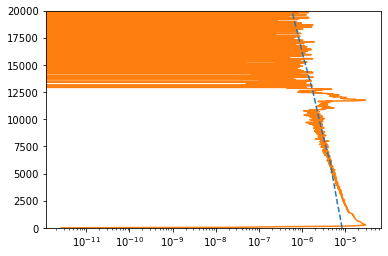

In [166]:
%matplotlib inline
fig, ax = plt.subplots()
ax.semilogx(new_simul[585,:], ipralrange, linestyle='--', zorder=10)
# ax.axvline(1)
ax.semilogx(new_signal[585,:], ipralrange)
ax.set_ylim(0, 20000)
# ax.set_xlim(-1, 20)

(1e-08, 1e-05)

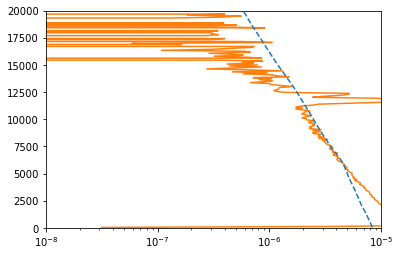

In [167]:
fig, ax = plt.subplots()
# ax.semilogx(new_signal[585, :(4000//4)].values.reshape([-1, 4000//4]).mean(axis=1), ipralrange[:(4000//4)].reshape([-1, 4000//6]).mean(axis=1))
ax.semilogx(new_simul[200, :(4000-4000%6)].reshape([4000//6,-1]).mean(axis=1), ipralrange[:(4000-4000%6)].reshape([4000//6,-1]).mean(axis=1), linestyle='--', zorder=10)
ax.semilogx(new_signal[200, :(4000-4000%6)].values.reshape([4000//6,-1]).mean(axis=1), ipralrange[:(4000-4000%6)].reshape([4000//6,-1]).mean(axis=1))
ax.set_ylim(0, 20000)
ax.set_xlim(1e-8, 1e-5)

In [129]:
new_signal[585, :(4000-4000%6)].shape

(3996,)